In [96]:
import torch
from torch import nn #neural network
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import make_circles
import pandas as pd

In [97]:
# Making 1000 samples
n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

len(X), len(y)

(1000, 1000)

In [98]:
print(X[:5,0])

[ 0.75424625 -0.75615888 -0.81539193 -0.39373073  0.44220765]


In [99]:
circles = pd.DataFrame({"X1":X[:,0],"X2":X[:,1], "label":y})


circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


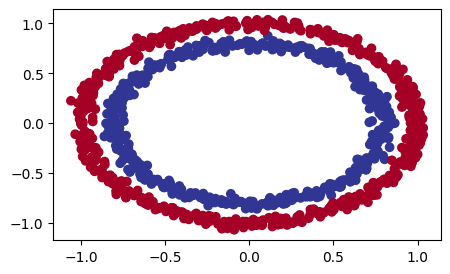

In [100]:
plt.figure(figsize=(5,3))
plt.scatter(x=X[:,0], y = X[:,1], c=y, cmap=plt.cm.RdYlBu);

In [101]:
# Example of feature and label

x_sample = X[0]
y_sample = y[0]
print(f"values for one sample of x : {x_sample}, and for y : {y_sample}")
print(f"shape of sample X : {x_sample.shape}, shape of sample y : {y_sample.shape}")

values for one sample of x : [0.75424625 0.23148074], and for y : 1
shape of sample X : (2,), shape of sample y : ()


In [102]:
X = torch.from_numpy(X).type(torch.float)

y = torch.from_numpy(y).type(torch.float)

X.dtype, y.dtype

(torch.float32, torch.float32)

In [103]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [104]:
# Split data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [105]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [106]:
# Setting up device agnostic code

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [107]:
# Subclassing nn.Module
class circleModelv0(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=5)
        self.linear2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x:torch.Tensor) ->torch.Tensor :
        return self.linear2(self.linear1(x))

model_0 = circleModelv0().to(device)
model_0

circleModelv0(
  (linear1): Linear(in_features=2, out_features=5, bias=True)
  (linear2): Linear(in_features=5, out_features=1, bias=True)
)

In [108]:
next(model_0.parameters()).device

device(type='cpu')

In [109]:
model_0.state_dict()

OrderedDict([('linear1.weight',
              tensor([[ 0.4292, -0.1678],
                      [ 0.4045, -0.5494],
                      [-0.3568,  0.2156],
                      [ 0.1495, -0.1803],
                      [ 0.4215,  0.4807]])),
             ('linear1.bias',
              tensor([-0.5128, -0.3775,  0.6475, -0.2386, -0.2507])),
             ('linear2.weight',
              tensor([[-0.4327, -0.2561,  0.1117, -0.0590, -0.3246]])),
             ('linear2.bias', tensor([0.0105]))])

In [110]:
# Replicating the model above with nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [111]:
# Make predictions

with torch.inference_mode():
    y_pred = model_0(X_test.to(device))

    print(f"Length of predictions : {len(y_pred)}, shape : {y_pred.shape}")
    print(f"Length of test samples : {len(X_test)}, shape : {X_test.shape}")
    print(f"First 10 predictions : {y_pred[:10]}")
    print(f"First 10 labels : {y[:10]}")

Length of predictions : 200, shape : torch.Size([200, 1])
Length of test samples : 200, shape : torch.Size([200, 2])
First 10 predictions : tensor([[-0.0210],
        [ 0.1162],
        [-0.2562],
        [ 0.0451],
        [-0.0581],
        [ 0.0242],
        [ 0.2538],
        [ 0.2327],
        [-0.2642],
        [ 0.1276]])
First 10 labels : tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.])


In [112]:
# Defining a loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.1)

In [113]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [114]:
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0210],
        [ 0.1162],
        [-0.2562],
        [ 0.0451],
        [-0.0581]])

In [115]:
y_pred_probability = torch.sigmoid(y_logits)
y_pred_probability

tensor([[0.4947],
        [0.5290],
        [0.4363],
        [0.5113],
        [0.4855]])

In [116]:
# Find the predicted labels
y_preds = torch.round(y_pred_probability)

y_pred_label = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
print(torch.eq(y_preds.squeeze(), y_pred_label.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 1., 0., 1., 0.])

In [117]:
y_test[:5], y_pred_label[:5].squeeze()

(tensor([1., 0., 1., 0., 1.]),
 tensor([0., 1., 0., 1., 0.], grad_fn=<SqueezeBackward0>))

In [118]:
# Creating training and testing loop

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)

epochs = 100
train_loss = []
test_loss = []

for epoch in range(epochs):
    model_0.train()
    y_logits = model_0(X_train.to(device)).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train.to(device)) # nn.BCEWithLogitsLoss

    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward() #backpropagation

    optimizer.step() #update weights and biases

    model_0.eval()

    with torch.inference_mode():
        t_logits = model_0(X_test.to(device)).squeeze()
        test_preds = torch.round(torch.sigmoid(t_logits))
        t_loss = loss_fn(t_logits, y_test.to(device))

        t_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)

        if epoch%10==0:
            print(f"Epoch : {epoch}, loss : {loss:.5f}, acc : {acc:.2f}%, test loss : {t_loss:.5f}, test accuracy : {t_acc:.2f}%")


Epoch : 0, loss : 0.69611, acc : 50.38%, test loss : 0.70322, test accuracy : 48.00%
Epoch : 10, loss : 0.69525, acc : 50.25%, test loss : 0.70130, test accuracy : 48.50%
Epoch : 20, loss : 0.69467, acc : 49.75%, test loss : 0.69986, test accuracy : 49.00%
Epoch : 30, loss : 0.69427, acc : 49.88%, test loss : 0.69876, test accuracy : 48.50%
Epoch : 40, loss : 0.69398, acc : 50.12%, test loss : 0.69791, test accuracy : 48.50%
Epoch : 50, loss : 0.69377, acc : 49.75%, test loss : 0.69725, test accuracy : 48.00%
Epoch : 60, loss : 0.69362, acc : 49.38%, test loss : 0.69674, test accuracy : 48.50%
Epoch : 70, loss : 0.69351, acc : 49.25%, test loss : 0.69633, test accuracy : 49.00%
Epoch : 80, loss : 0.69342, acc : 49.38%, test loss : 0.69600, test accuracy : 49.50%
Epoch : 90, loss : 0.69335, acc : 49.50%, test loss : 0.69574, test accuracy : 49.50%


In [119]:
# Downloading helper_funtions.py for plotting decision boundary

# import requests
# from pathlib import Path
#
# if Path('helper_funcations.py').is_file():
#     print("The file already exists")
#
# else:
#     print("Downloading helper_funcitons.py")
#     request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
#     with open('helper_functions.py','wb') as f:
#         f.write(request.content)


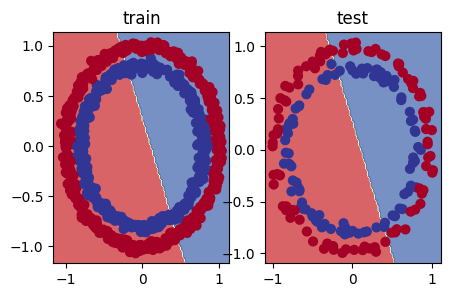

In [120]:
# Plotting decision boundary

from helper_functions import plot_decision_boundary

plt.figure(figsize=(5,3))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model_0, X_train, y_train)


plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_0, X_test, y_test)